<a href="https://colab.research.google.com/github/IvanKatorgin/Time-series/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Временные ряды". Домашнее задание 2. Элементарные методы анализа временных рядов. Каторгин И.П.

Описание задания

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [595]:
# загрузим библиотеки
import numpy as np, pandas as pd, seaborn as sns, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# загрузим данные
female_births = pd.read_csv('daily-total-female-births-in-cal.csv', sep = ',', header = 0, encoding = 'utf-8')
airlines_passengers = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, encoding = 'utf-8')
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', sep = ',', header = 0, encoding = 'utf-8')
robberies_in_boston = pd.read_csv('monthly-boston-armed-robberies-j.csv', sep = ',', header = 0, encoding = 'utf-8')
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep = ',', header = 0, encoding = 'utf-8')
dowjones_closing = pd.read_csv('weekly-closings-of-the-dowjones-.csv', sep = ',', header = 0, encoding = 'utf-8')

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

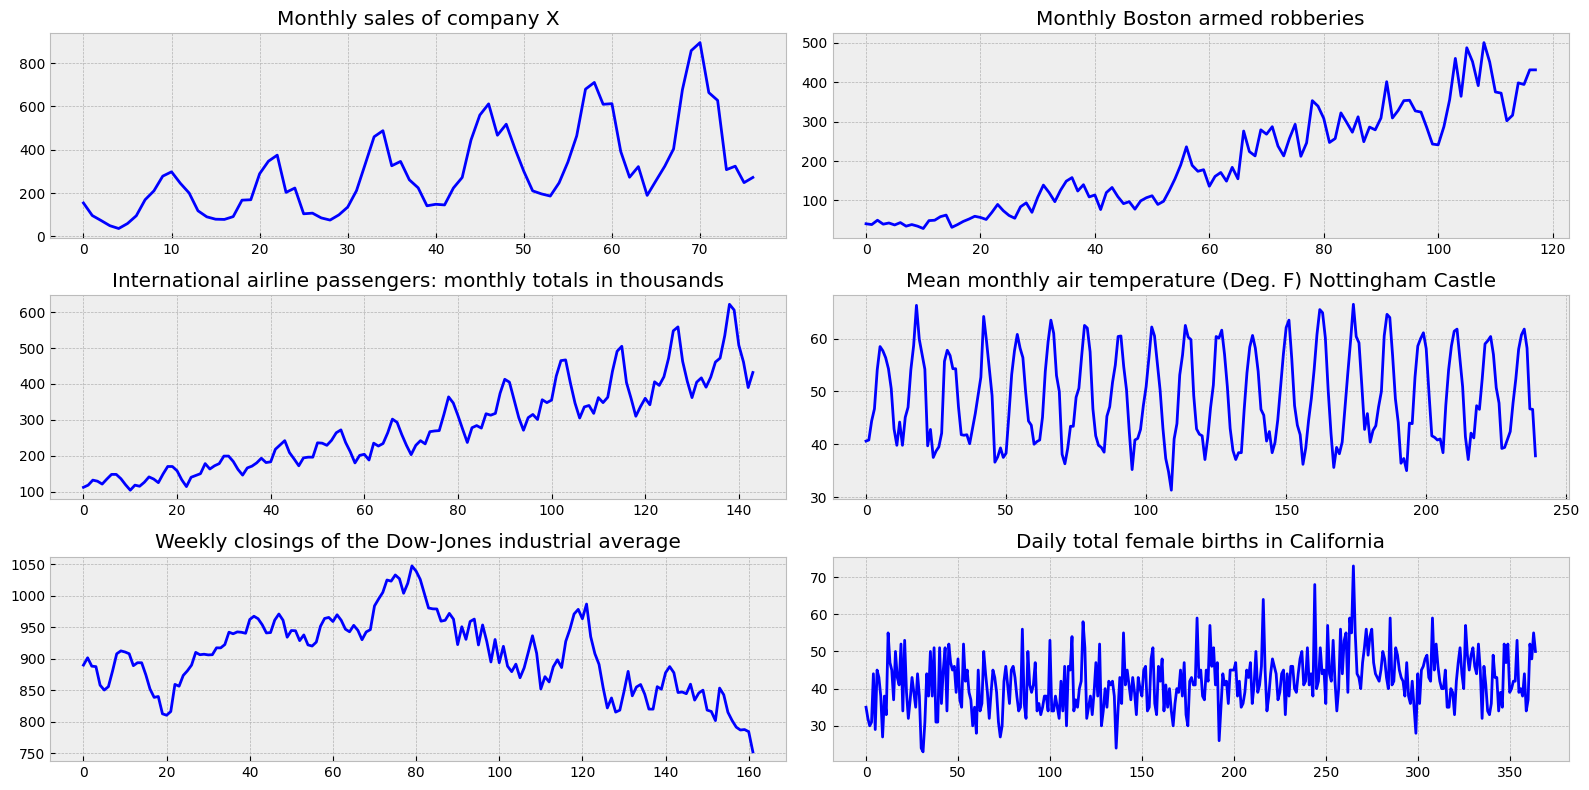

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Из домашнего задания 1 мы знаем, что ряд "Daily total female births in California" - стационарный, остальные - нет

## Стационарный ряд. Скользящая средняя

Для ряда "Daily total female births in California" нет ни сезонности, ни тренда, поэтому посчитаем обычную скользящую среднюю

In [ ]:
# напишем функцию для расчета скользящей средней
def moving_average_(x, w):
  np.convolve(x, np.ones(w), 'valid') / w
  return x.rolling(w).mean()

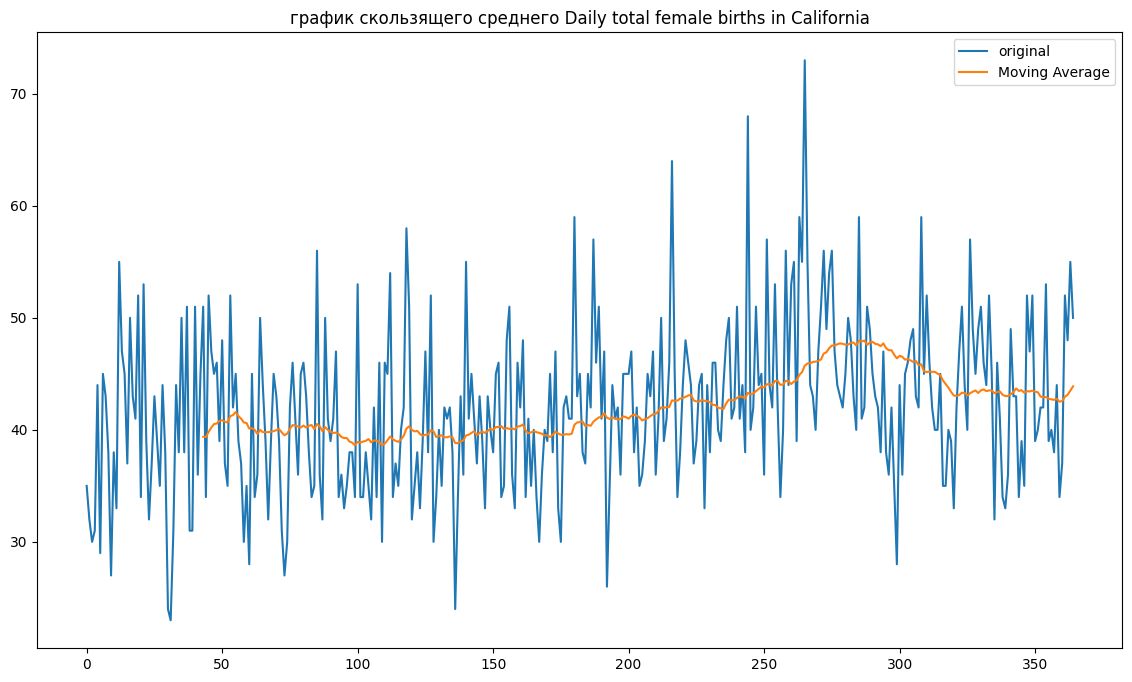

In [ ]:
# посчитаем скользящую среднюю и построим график
MA = moving_average_(all_series["Daily total female births in California"], 44)

# построим график
plt.figure(figsize=(14, 8))
plt.plot(all_series["Daily total female births in California"], label='original')
plt.plot(MA, label='Moving Average')
plt.title("график скользящего среднего Daily total female births in California")
plt.legend()

In [ ]:
# способ из практики
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

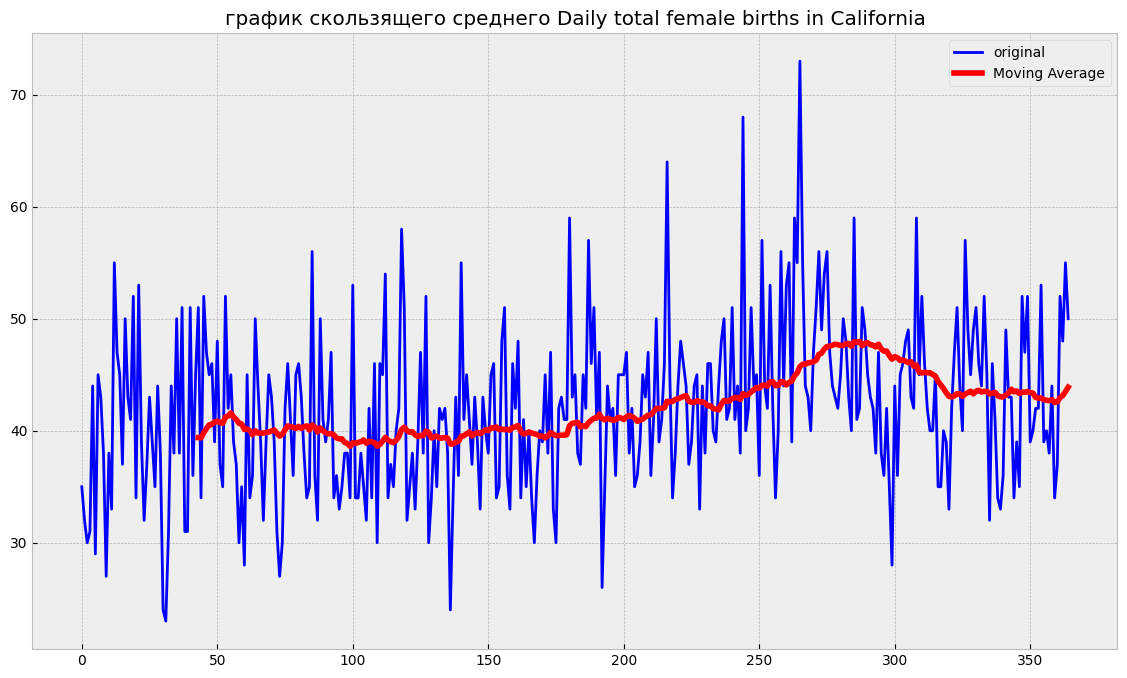

In [ ]:
ser = moving_average(all_series["Daily total female births in California"], 44)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Daily total female births in California"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.title("график скользящего среднего Daily total female births in California")
    plt.legend()

In [ ]:
# Напишем функцию, которая предсказывает следующие измерения временного ряда
def predict(series, N, n_pred):
  new_series = series.copy()
  for _ in range(n_pred):
    new_series = new_series._append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
  return new_series

In [ ]:
series_pred = predict(all_series["Daily total female births in California"], 44, 50)

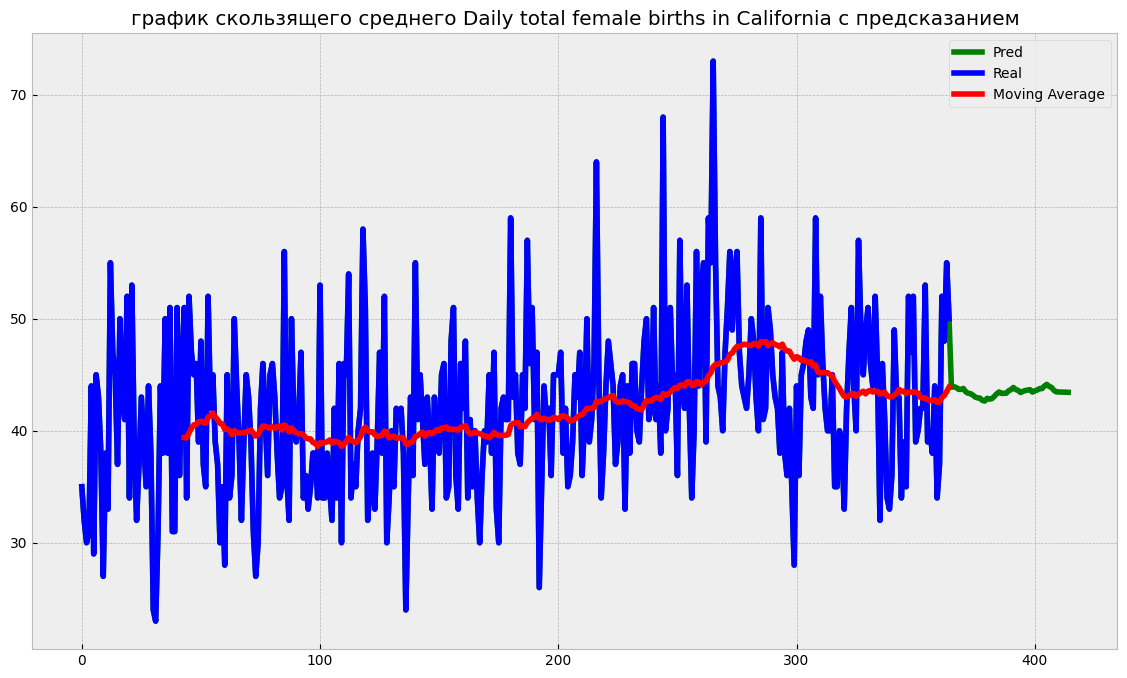

In [ ]:
# особразим все на графике
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(all_series["Daily total female births in California"], color='blue', linewidth='4', label='Real')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.title("график скользящего среднего Daily total female births in California с предсказанием")
    plt.legend()

In [ ]:
# разделим ряд на тренировочную и тестовую части
train, test = all_series["Daily total female births in California"][:300], all_series["Daily total female births in California"][300:]

In [ ]:
result = predict(train, 44, len(test))
predictions = result[-len(test):]

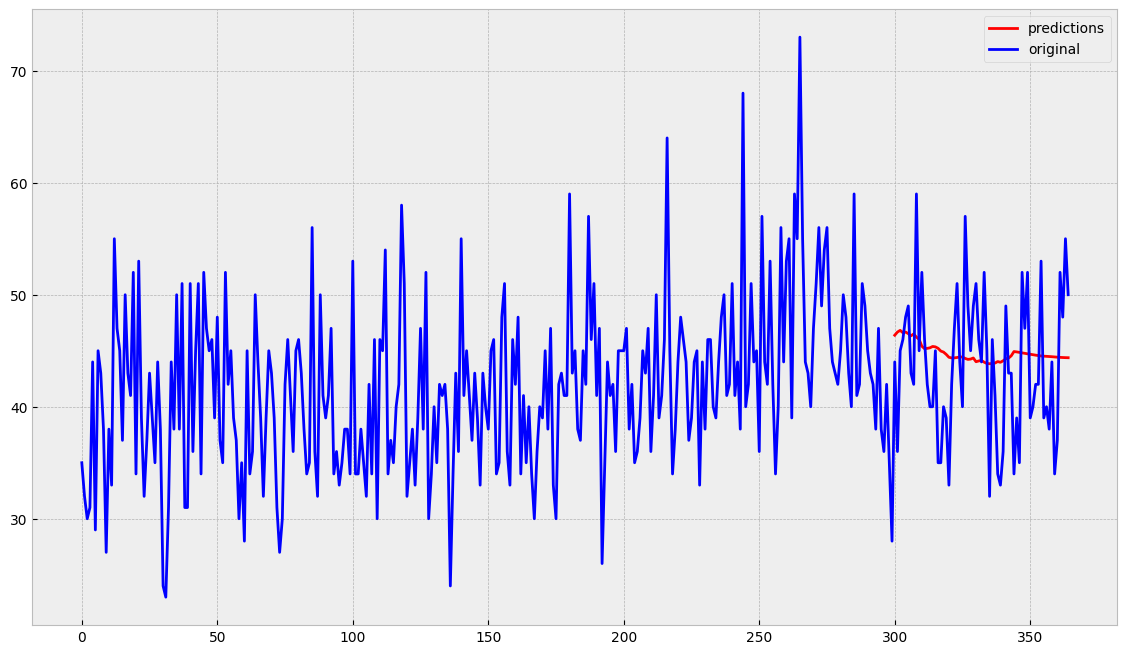

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(predictions, color = 'red', label = 'predictions')
  plt.plot(all_series["Daily total female births in California"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# посчитаем ошибку
mean_squared_error(predictions, test)

41.022513585667596

В целом ошибка получилась довольно низкой

Посчитаем прогноз и ошибку на скользящей средней

In [ ]:
# разделим ряд на тренировочную и тестовую части
train, test = ser[:300], ser[300:]

In [ ]:
result = predict(train, 44, len(test))
predictions = result[-len(test):]

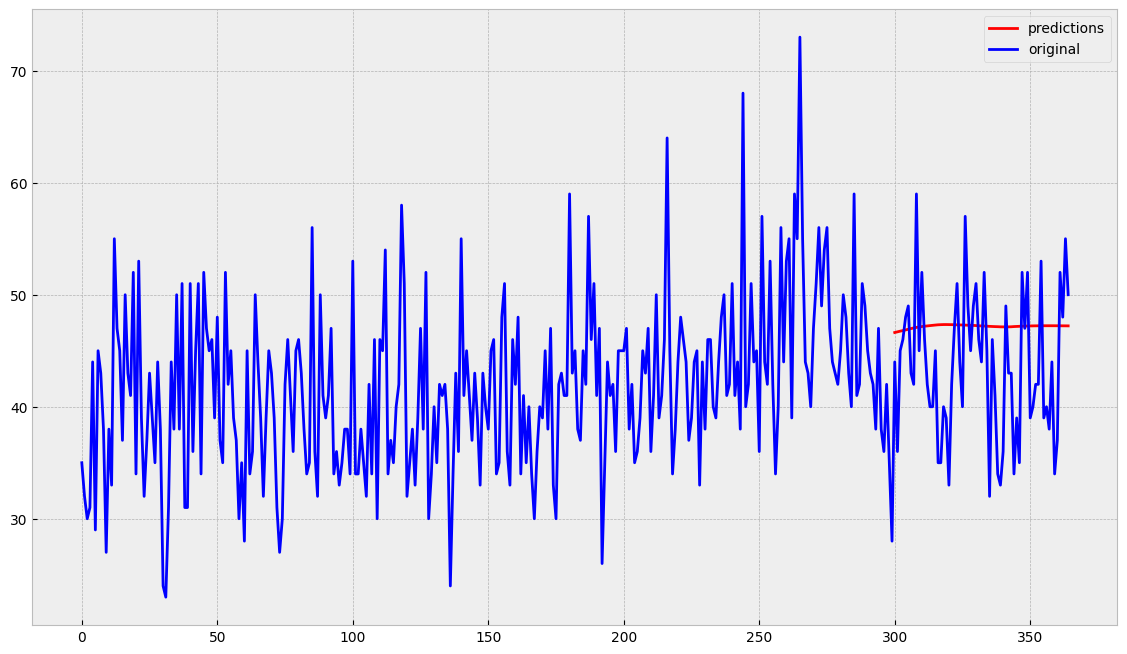

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(predictions, color = 'red', label = 'predictions')
  plt.plot(all_series["Daily total female births in California"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# посчитаем ошибку
mean_squared_error(predictions, test)

12.375118922272783

Ошибка получилась еще меньшей

## Стационарный ряд. Взвешенная скользящая средняя

Модификацией обычной скользящей средней является взвешенная скользящая средняя. Для ряда "Daily total female births in California" попробуем также посчитать ее, и затем также сделаем прогноз

In [ ]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [ ]:
wma = weighted_moving_average(all_series["Daily total female births in California"], 10, [1,2,4,8,16,32,64,128,256,512])

In [ ]:
series_pred_wma = predict(wma, 10, 50)

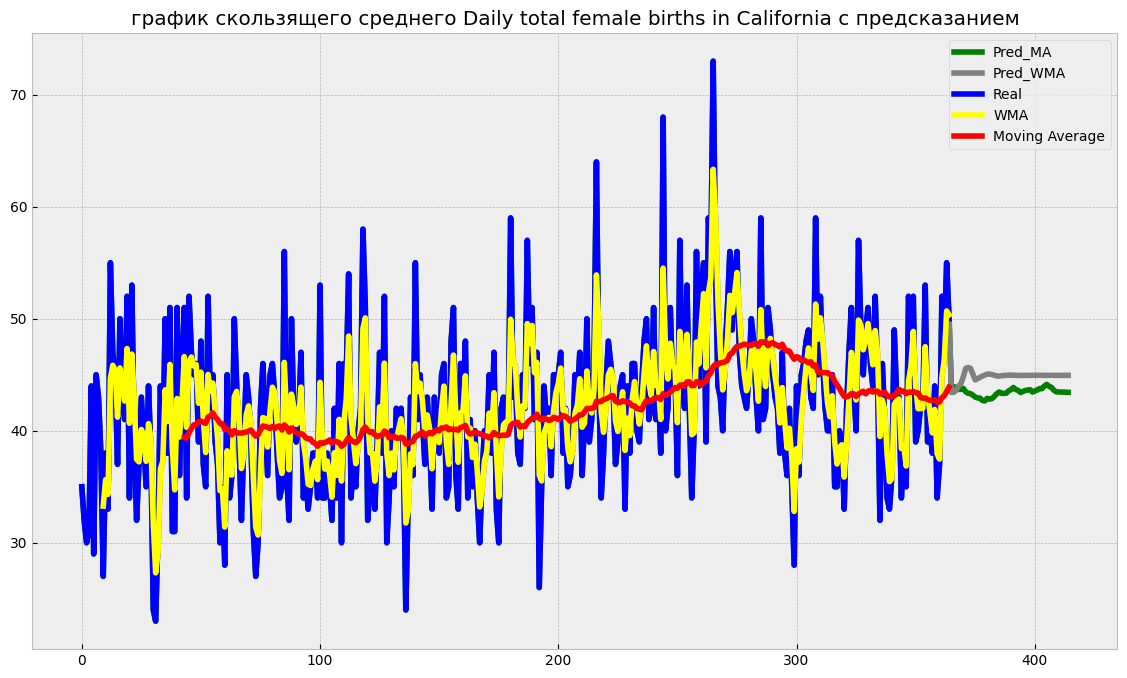

In [ ]:
# посмотрим на все на графике
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred_MA')
    plt.plot(series_pred_wma, color='gray', linewidth='4', label='Pred_WMA')
    plt.plot(all_series["Daily total female births in California"], color='blue', linewidth='4', label='Real')
    plt.plot(wma, color='yellow', linewidth='4', label='WMA')
    plt.plot((moving_average(all_series["Daily total female births in California"], 44)), color='red', linewidth='4', label='Moving Average')
    plt.title("график скользящего среднего Daily total female births in California с предсказанием")
    plt.legend()

Посчитаем прогноз и ошибку на взвешенной скользящей средней

In [ ]:
# разделим ряд на тренировочную и тестовую части
train, test = wma[:300], wma[300:]

In [ ]:
result = predict(train, 10, len(test))
predictions = result[-len(test):]

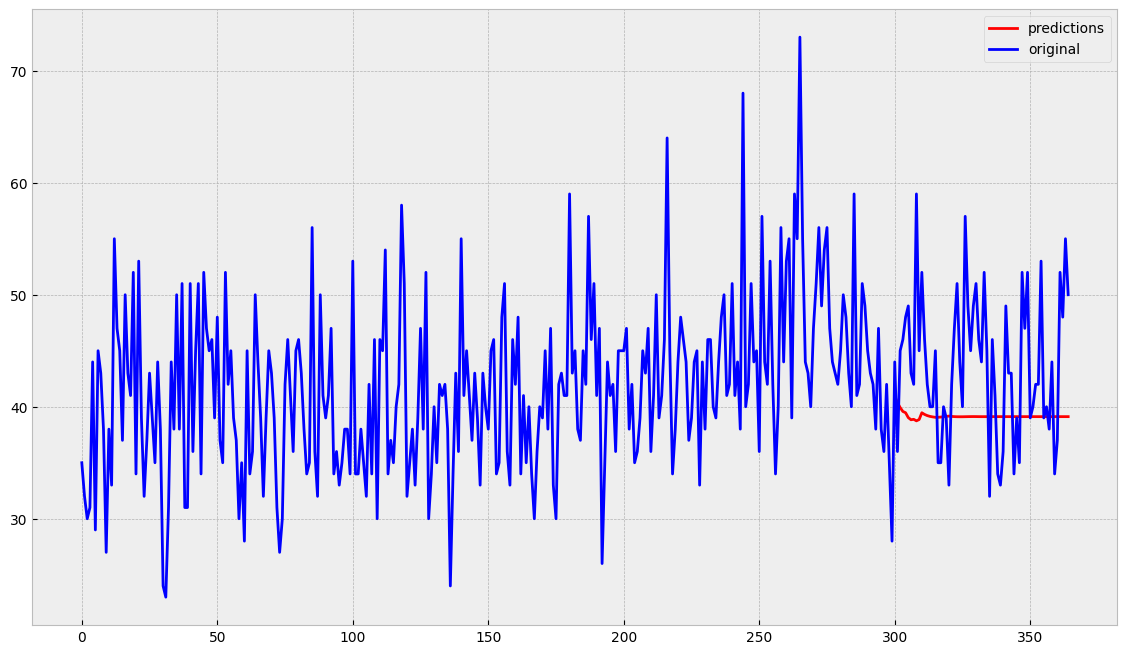

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(predictions, color = 'red', label = 'predictions')
  plt.plot(all_series["Daily total female births in California"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# посчитаем ошибку
mean_squared_error(predictions, test)

36.411576969947234

В целом ошибка получилась довольно низкой

В целом для стационарных рядов, таких как "Daily total female births in California", обычная скользящая средняя на 44 интервалах показывает лучшие результаты, чем взвешенная скользящая средняя на 10 интервалах

## Нестационарный ряд. Экспоненциальное сглаживание

Для ряда "Weekly closings of the Dow-Jones industrial average" нет сезонности и тренд выражен неявно, поэтому посчитаем экспоненциальное сглаживание

In [ ]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
ema = exponential_moving_average(all_series["Weekly closings of the Dow-Jones industrial average"], 0.2)

In [ ]:
len(ema)

162

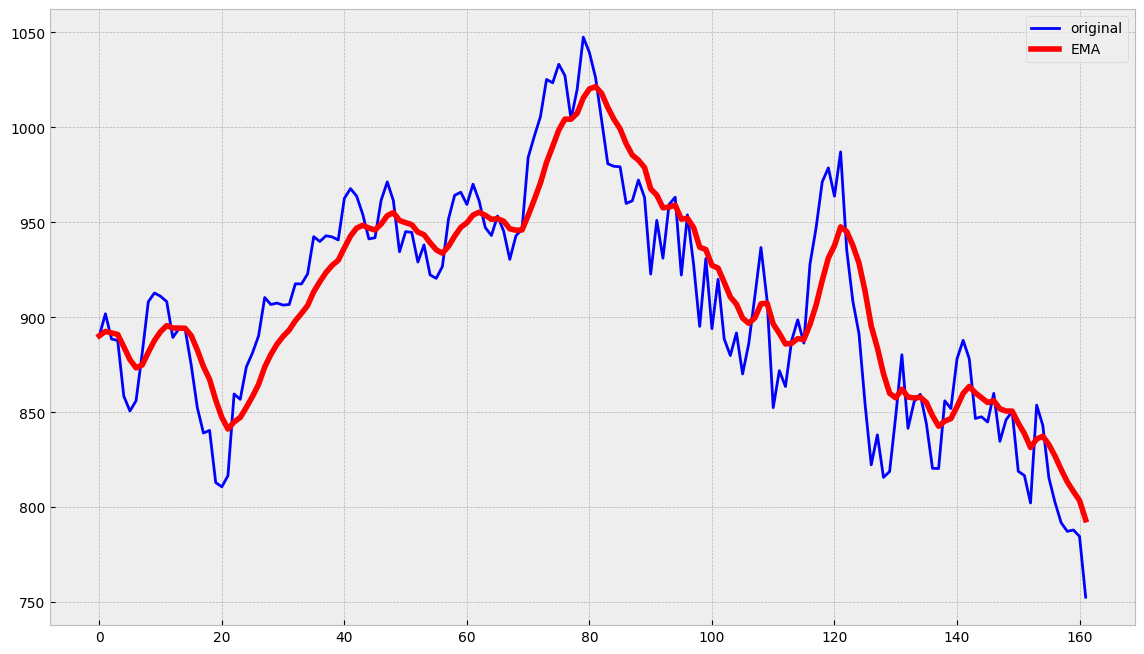

In [ ]:
# построим график
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color='blue',label='original')
    plt.plot(ema, color='red', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
# сделаем прогноз
def exponential_moving_average_predict(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series._append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [ ]:
pred_ema, _ = exponential_moving_average_predict(all_series["Weekly closings of the Dow-Jones industrial average"], 0.2, 50)

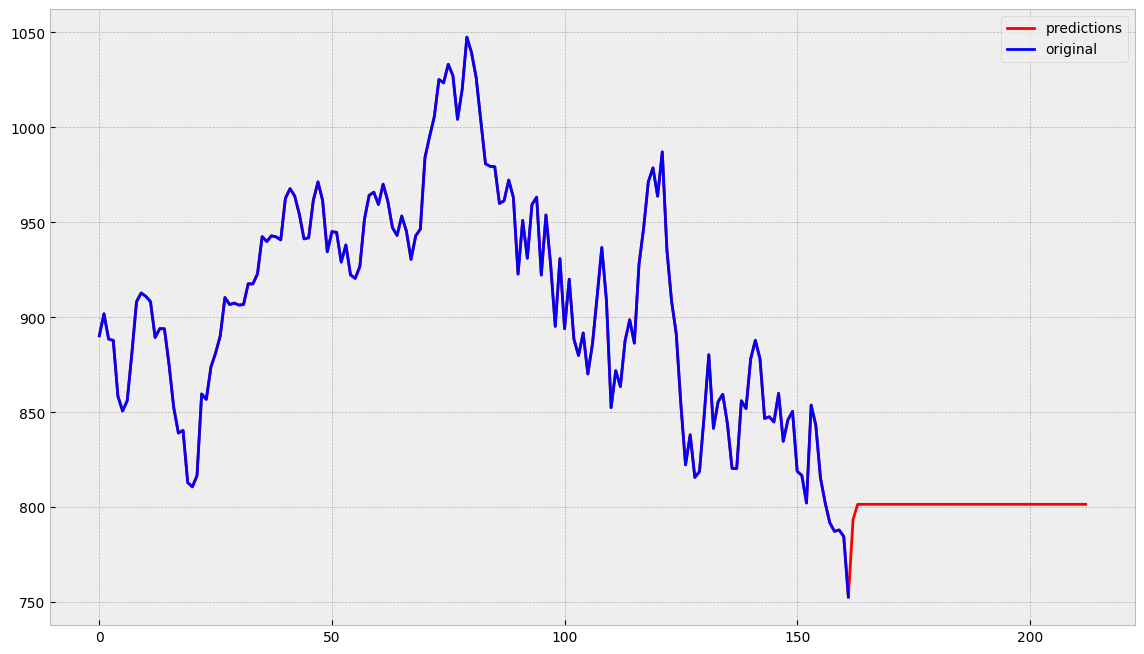

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(pred_ema, color = 'red', label = 'predictions')
  plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# разделим ряд на тренировочную и тестовую части
train, test = all_series["Weekly closings of the Dow-Jones industrial average"][:100], all_series["Weekly closings of the Dow-Jones industrial average"][100:]

In [ ]:
result_ema, _ = exponential_moving_average_predict(train, 0.2, len(test))
predictions_ema = result_ema[-len(test):]

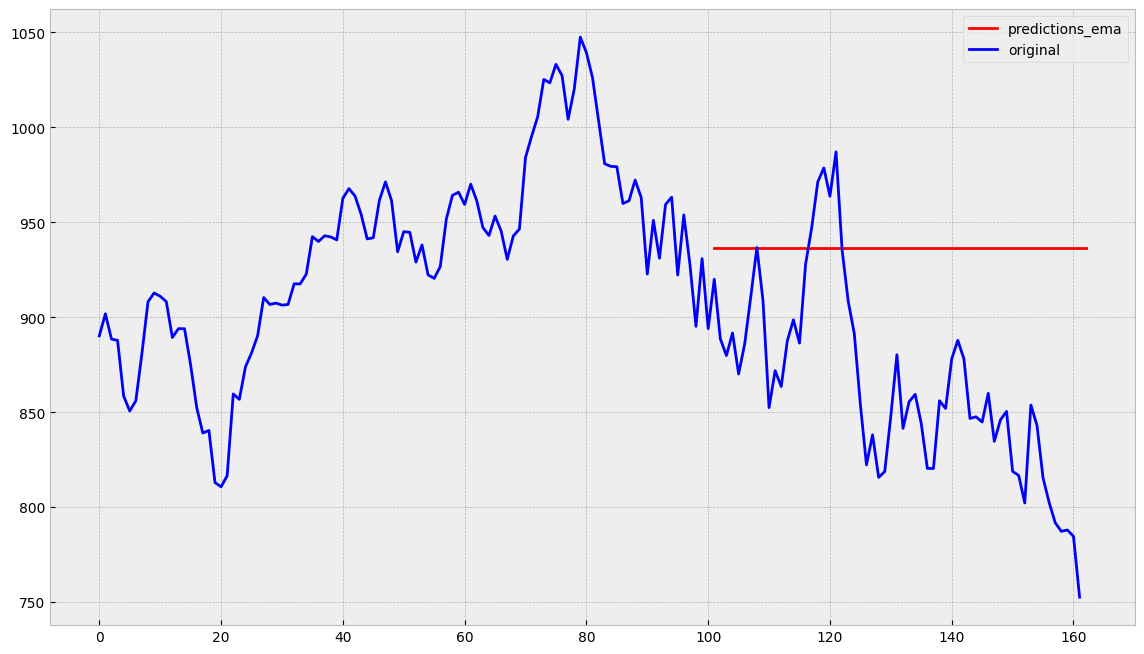

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(predictions_ema, color = 'red', label = 'predictions_ema')
  plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# посчитаем ошибку
mean_squared_error(predictions_ema, test)

7628.1383824467985

In [ ]:
# разделим ряд на тренировочную и тестовую части для ema
train, test = ema[:100], ema[100:]

In [ ]:
result_ema, _ = exponential_moving_average_predict(train, 0.2, len(test))
predictions_ema = result_ema[-len(test):]

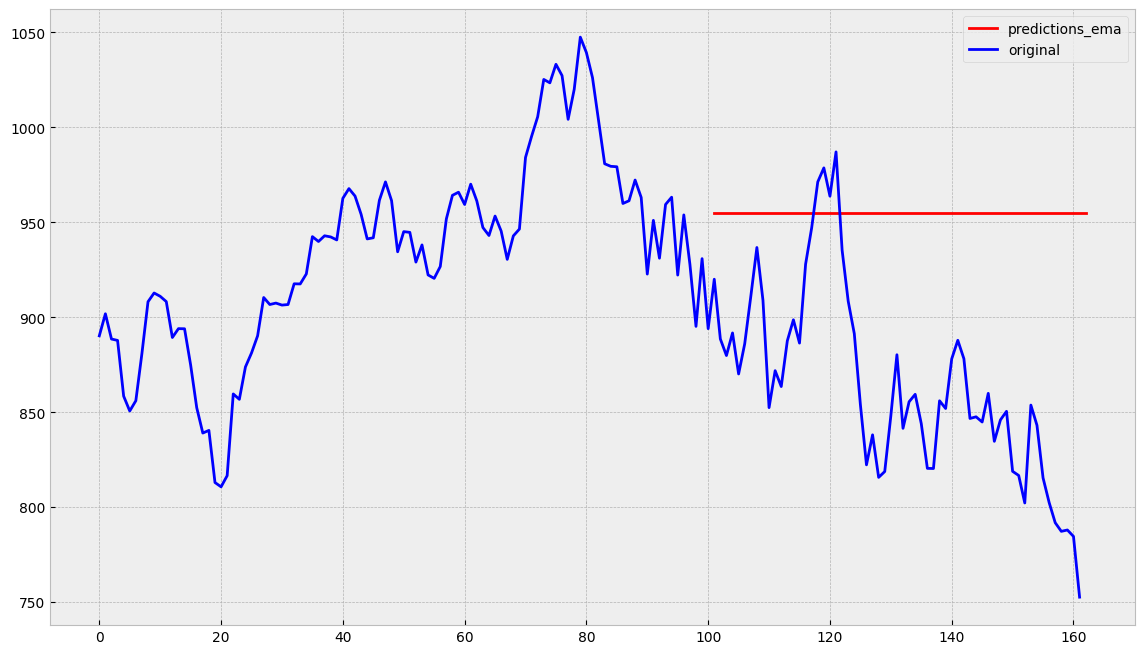

In [ ]:
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(predictions_ema, color = 'red', label = 'predictions_ema')
  plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# посчитаем ошибку
mean_squared_error(predictions_ema, test)

8002.566316696261

Вывод: в обоих случаях ошибка очень большая

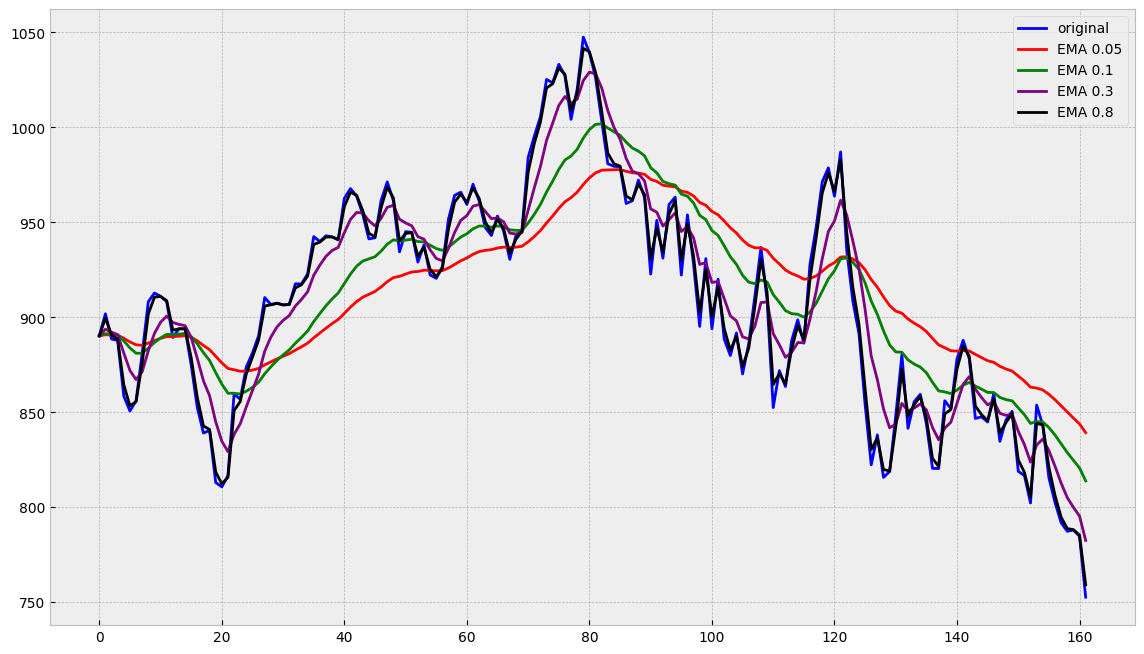

In [ ]:
# построим график для разных значений альфа
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(all_series["Weekly closings of the Dow-Jones industrial average"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Чем больше значение альфа, тем сильнее ЕМА повторяет начальный ряд

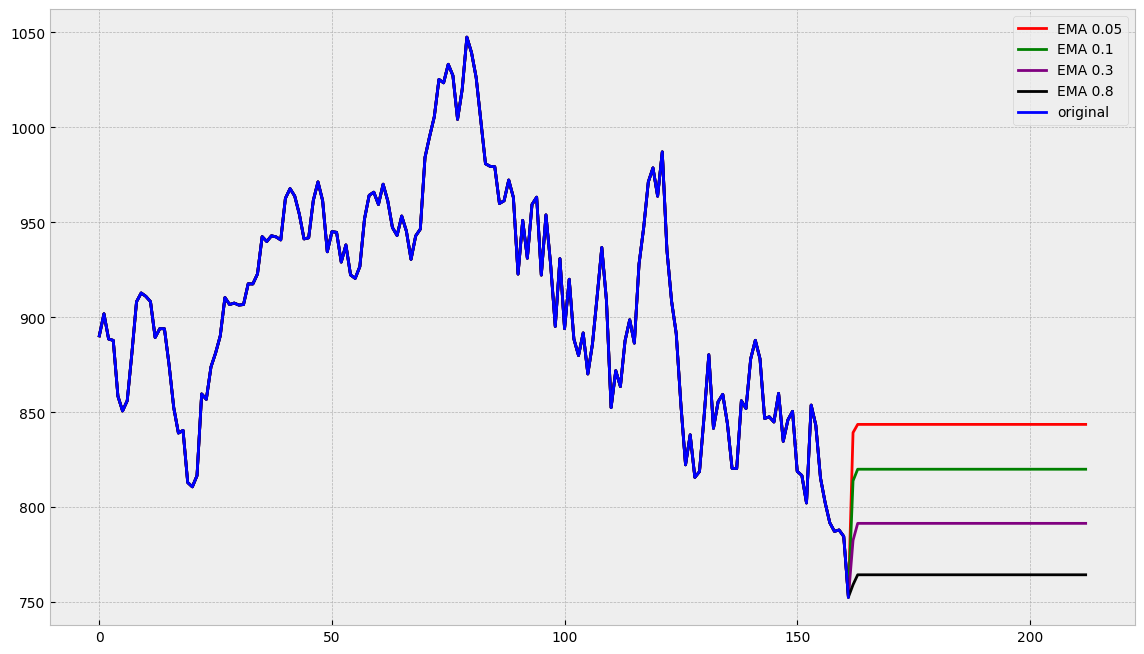

In [ ]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser_, _ = exponential_moving_average_predict(all_series["Weekly closings of the Dow-Jones industrial average"], alphas[i], 50)
        plt.plot(ser_, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(all_series["Weekly closings of the Dow-Jones industrial average"], color='blue',label='original')
    plt.legend()

## Нестационарный ряд. Двойное сглаживание

Для ряда "Monthly Boston armed robberies" нет сезонности, но есть тренд, поэтому посчитаем двойное экспоненциальное сглаживание

In [ ]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(all_series["Monthly Boston armed robberies"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(all_series["Monthly Boston armed robberies"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

Построим графики с различными параметрами альфа и бета, чтобы понять, как они влияют на построение

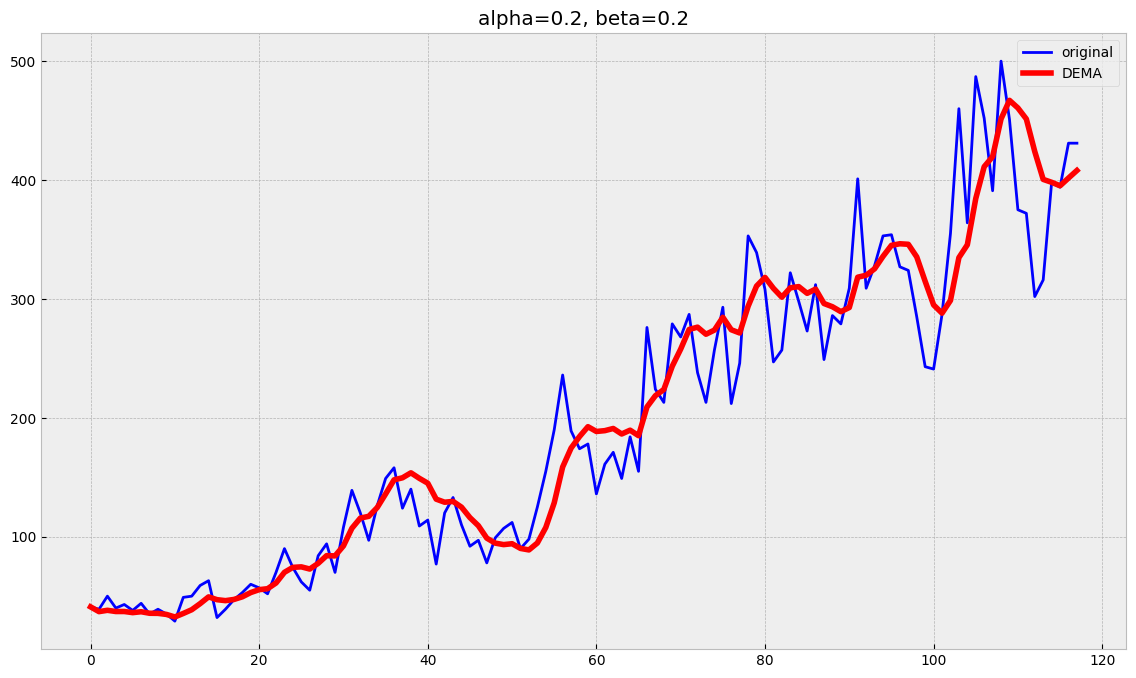

In [ ]:
plot_dema(0.2, 0.2)

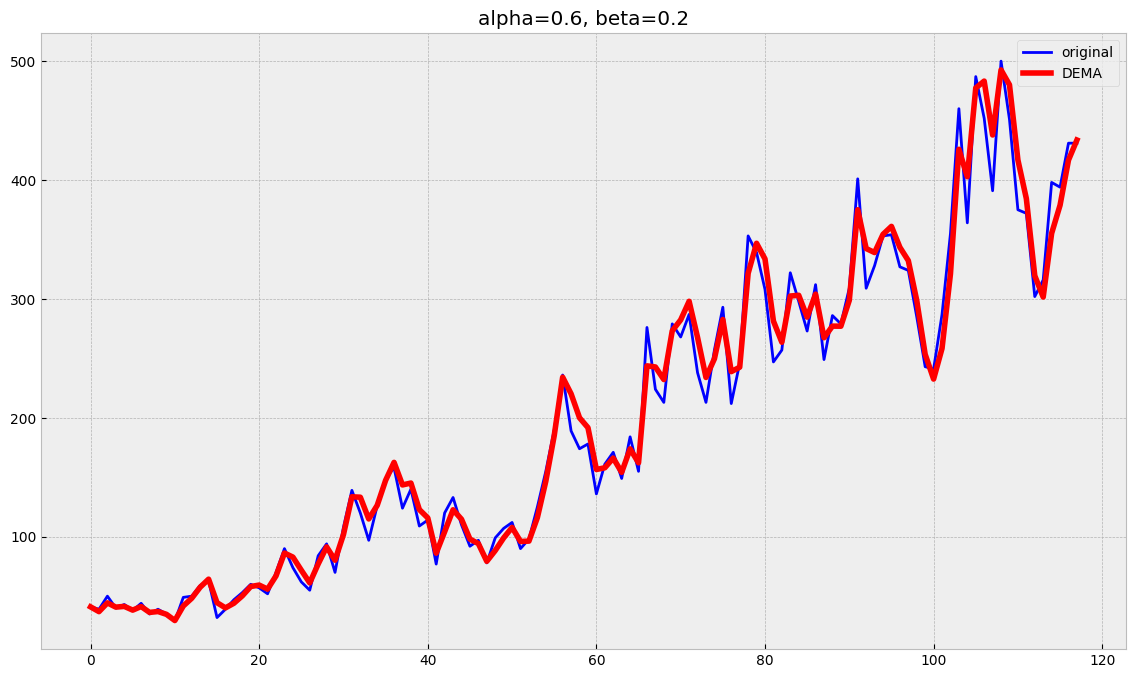

In [ ]:
plot_dema(0.6, 0.2)

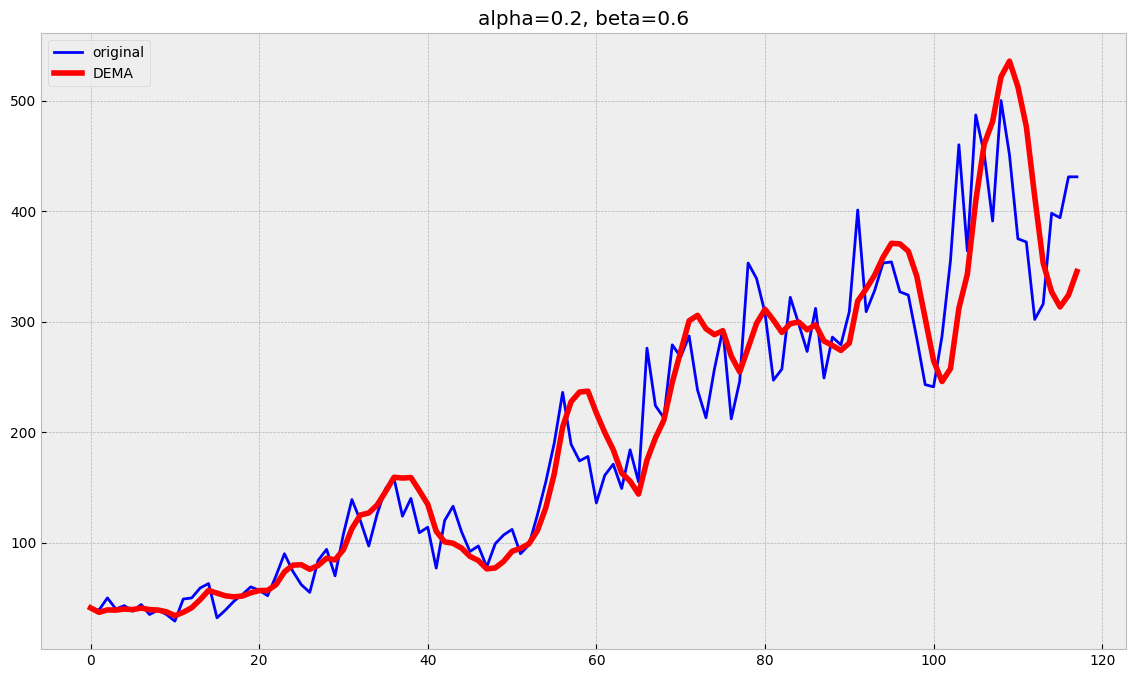

In [ ]:
plot_dema(0.2, 0.6)

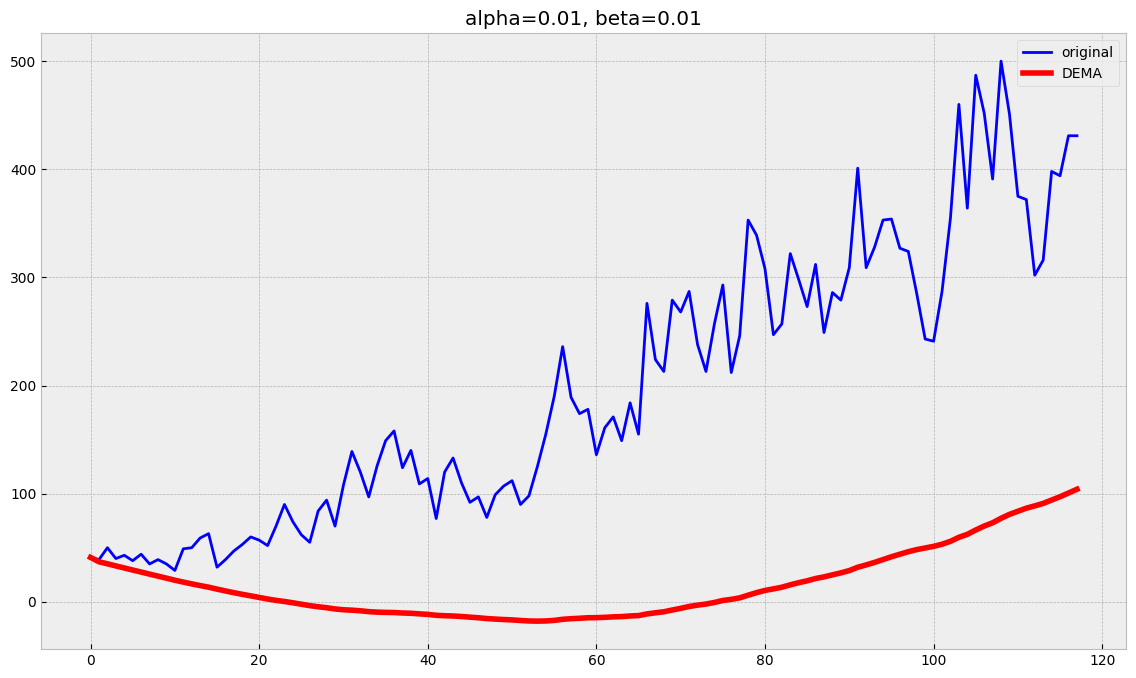

In [ ]:
plot_dema(0.01, 0.01)

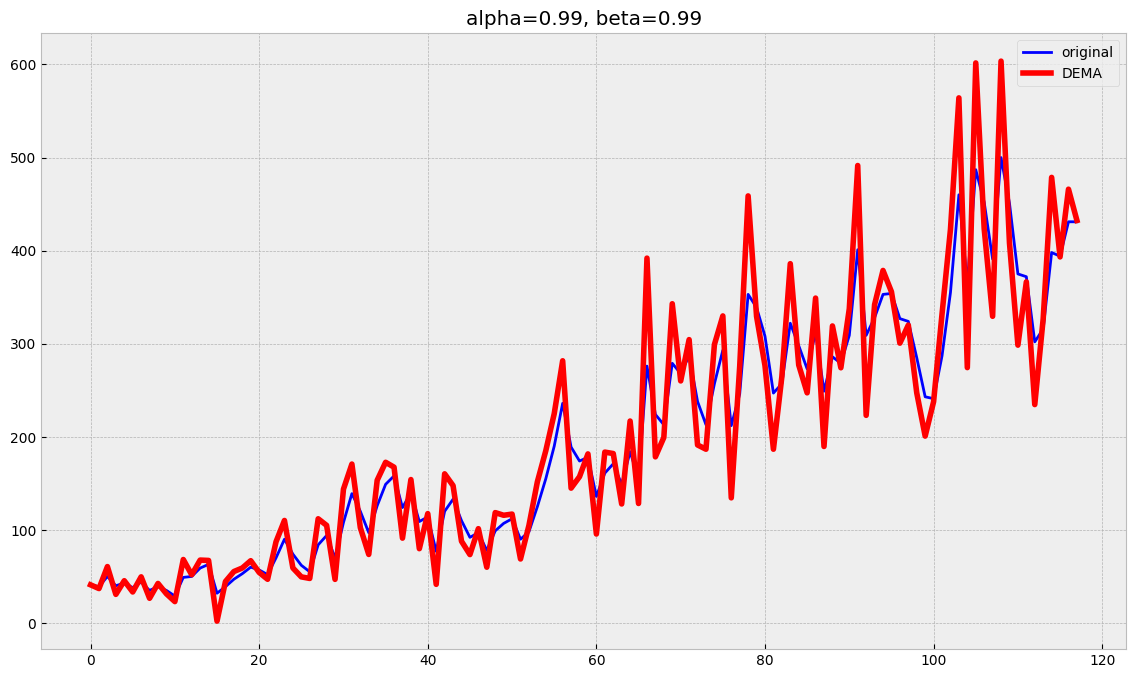

In [ ]:
plot_dema(0.99, 0.99)

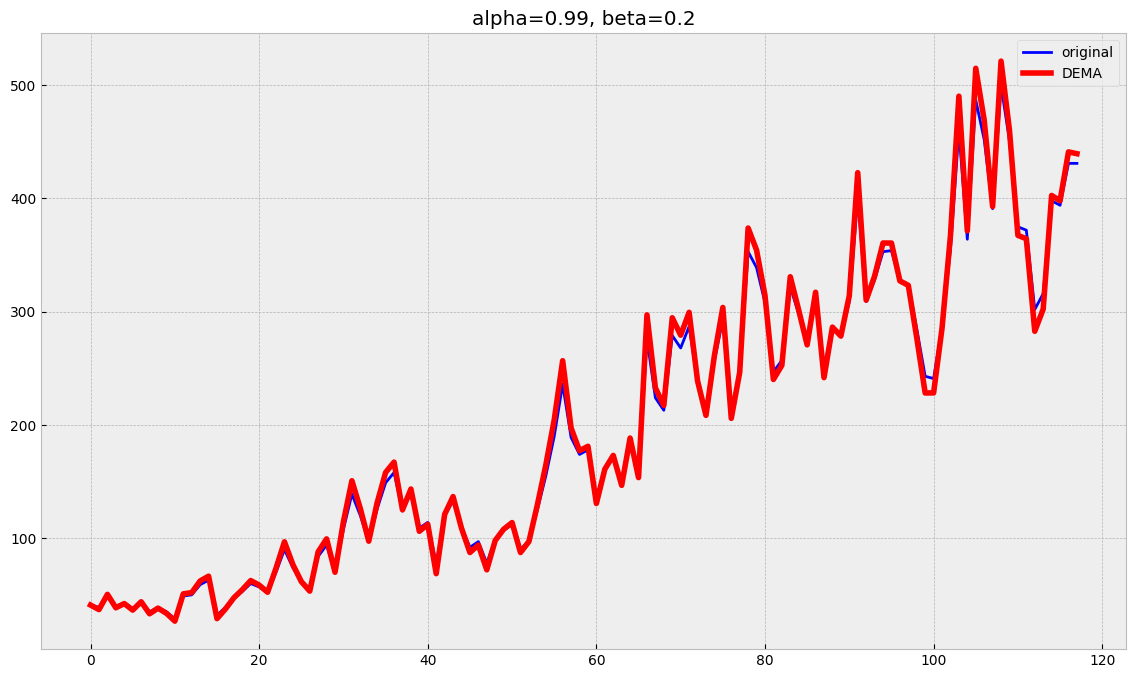

In [ ]:
plot_dema(0.99, 0.2)

In [ ]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series._append(pd.Series(preds), ignore_index=True), pd.Series(result)

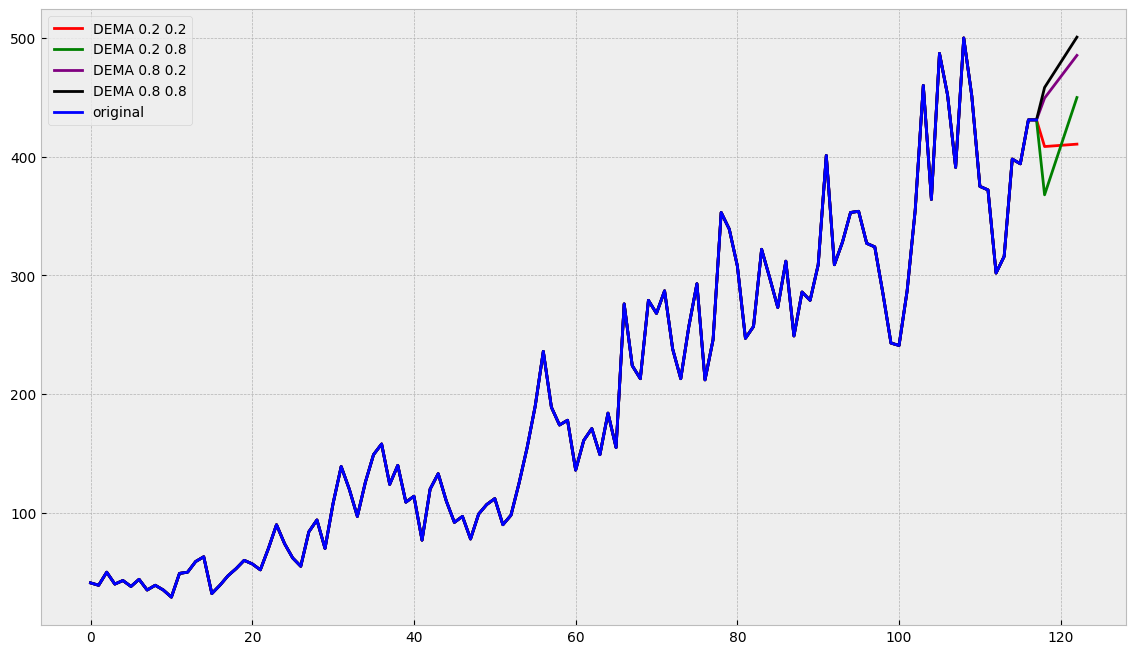

In [ ]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(all_series["Monthly Boston armed robberies"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(all_series["Monthly Boston armed robberies"], color='blue',label='original')
    plt.legend()

Возьмем одну пару значений альфа и бета и для нее посчитаем прогноз и оченим качество

In [ ]:
pred_dema, _ = double_ema_with_preds(all_series["Monthly Boston armed robberies"], 0.2, 0.1, 50)

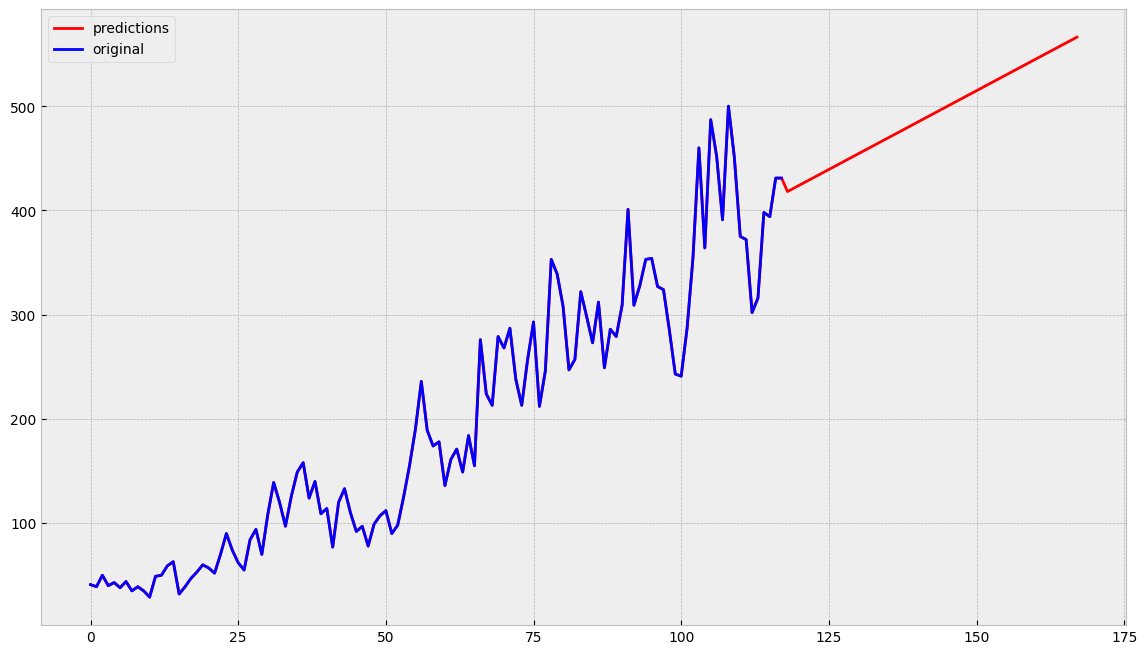

In [ ]:
# построим график
with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(pred_dema, color = 'red', label = 'predictions')
  plt.plot(all_series["Monthly Boston armed robberies"], color = 'blue', label = 'original')
  plt.legend()

In [ ]:
# разделим выборку на тренировочную и тестовую части
train, test = all_series["Monthly Boston armed robberies"][:80], all_series["Monthly Boston armed robberies"][80:]

In [ ]:
result_dema, _ = double_ema_with_preds(train, 0.2, 0.1, len(test))
predictions_dema = result_dema[-len(test):]

In [ ]:
mean_squared_error(predictions_dema, test)

15979.003471219155

Ошибка получилась довольно большой. Посчитаем на dema

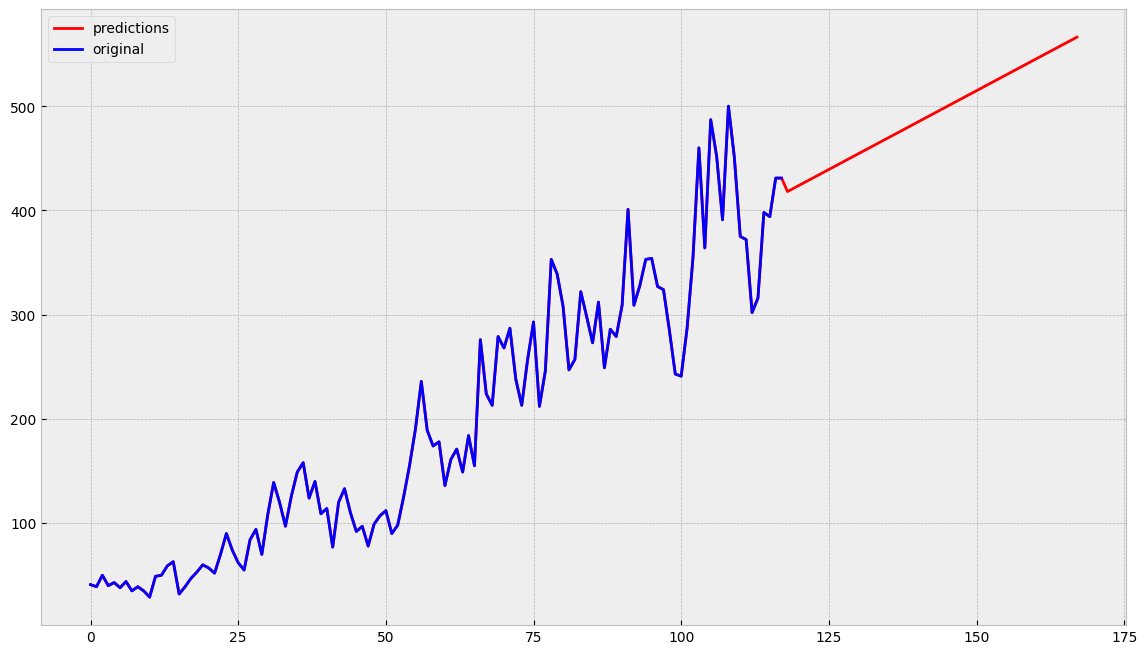

In [583]:
dema, _ = double_ema_with_preds(all_series["Monthly Boston armed robberies"], 0.2, 0.1, 50)

with plt.style.context('bmh'):
  plt.figure(figsize=(14,8))
  plt.plot(dema, color = 'red', label = 'predictions')
  plt.plot(all_series["Monthly Boston armed robberies"], color = 'blue', label = 'original')
  plt.legend()

In [584]:
# разделим выборку на тренировочную и тестовую части
train, test = dema[:80], dema[80:]

In [585]:
result_dema, _ = double_ema_with_preds(train, 0.2, 0.1, len(test))
predictions_dema = result_dema[-len(test):]

In [586]:
mean_squared_error(predictions_dema, test)

53940.85482250675

Ошибка значительно выросла

## Нестационарный ряд. Тройное сглаживание. Метод Хольта-Винтерса

Для рядов "Monthly sales of company X" и "International airline passengers: monthly totals in thousands" есть и сезонность, и тренд, поэтому для одного из них посчитаем тройное экспоненциальное сглаживание. Для ряда "Mean monthly air temperature (Deg. F) Nottingham Castle" тренд явно не выражен, но есть сезонность, поэтому для него также попробуем посчитать тройное экспоненциальное сглаживание

In [587]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [588]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [589]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [590]:
def plot_tema(alpha, beta, gamma, ser=all_series["International airline passengers: monthly totals in thousands"], ser_to_plot=all_series["International airline passengers: monthly totals in thousands"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

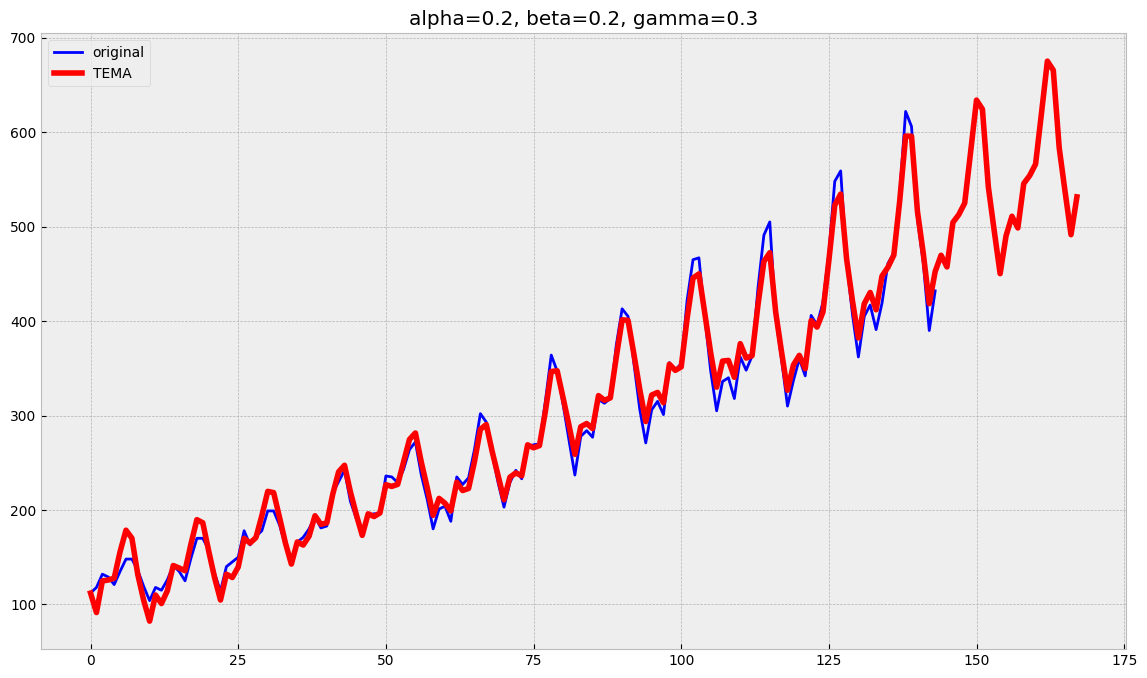

In [594]:
plot_tema(0.2, 0.2, 0.3)

# Подбор параметров

In [608]:
series = all_series["International airline passengers: monthly totals in thousands"]

In [609]:
train, test, val = series[:125], series[125:150], series[150:]

In [610]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [611]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [612]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1696.6441625825748
        x: [ 1.000e+00  4.025e-02  1.000e+00]
      nit: 9
      jac: [-4.309e+02 -4.093e-04 -0.000e+00]
     nfev: 44
     njev: 11
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


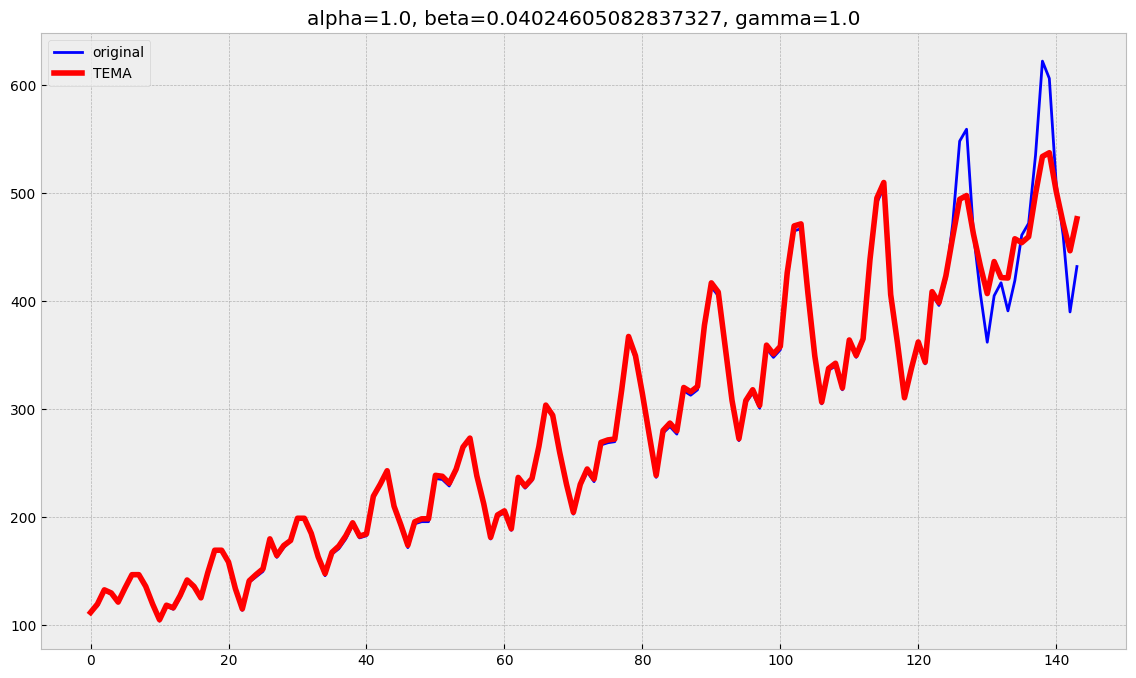

In [616]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:150], n_preds=len(test))

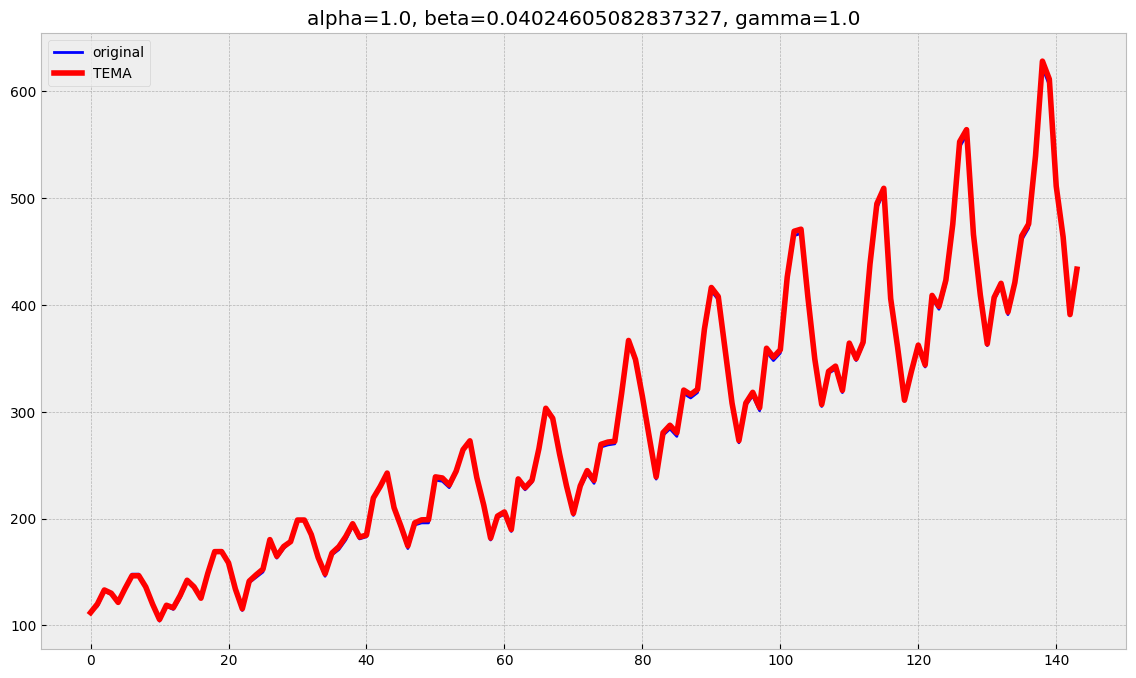

In [617]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:150], ser_to_plot=series, n_preds=len(val))

# Кросс-валидация

In [618]:
train, val = series[:125], series[125:]

In [619]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [620]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

36159.89293007693------------
35647.77002793573------------
36159.89293007693------------
36116.97329812861------------
35789.029711088195------------
35544.90668862471------------
35243.20946973149------------
35013.617441283706------------
34480.81391818959------------
34467.431191817705------------
33833.96303986028------------
33429.78638286974------------
32397.89693219977------------
31983.972712262563------------
30523.9200795572------------
30156.069074925505------------
28299.423114222198------------
27365.40573871192------------
24830.793654223544------------
24035.48072884156------------
21086.421081931836------------
20121.196456174108------------
16959.774861957296------------
15802.55659208388------------
12760.893928587704------------
11928.185269329793------------
9438.47272575392------------
8713.561724718727------------
6901.253123590562------------
6407.818754941895------------
5230.938030262715------------
4944.964332724267------------
4257.524965263718------------


In [621]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3141.284449304458
             x: [ 1.113e-01  0.000e+00  1.000e+00]
           nit: 103
          nfev: 194
 final_simplex: (array([[ 1.113e-01,  0.000e+00,  1.000e+00],
                       [ 1.114e-01,  0.000e+00,  1.000e+00],
                       [ 1.113e-01,  0.000e+00,  1.000e+00],
                       [ 1.114e-01,  0.000e+00,  1.000e+00]]), array([ 3.141e+03,  3.141e+03,  3.141e+03,  3.141e+03]))


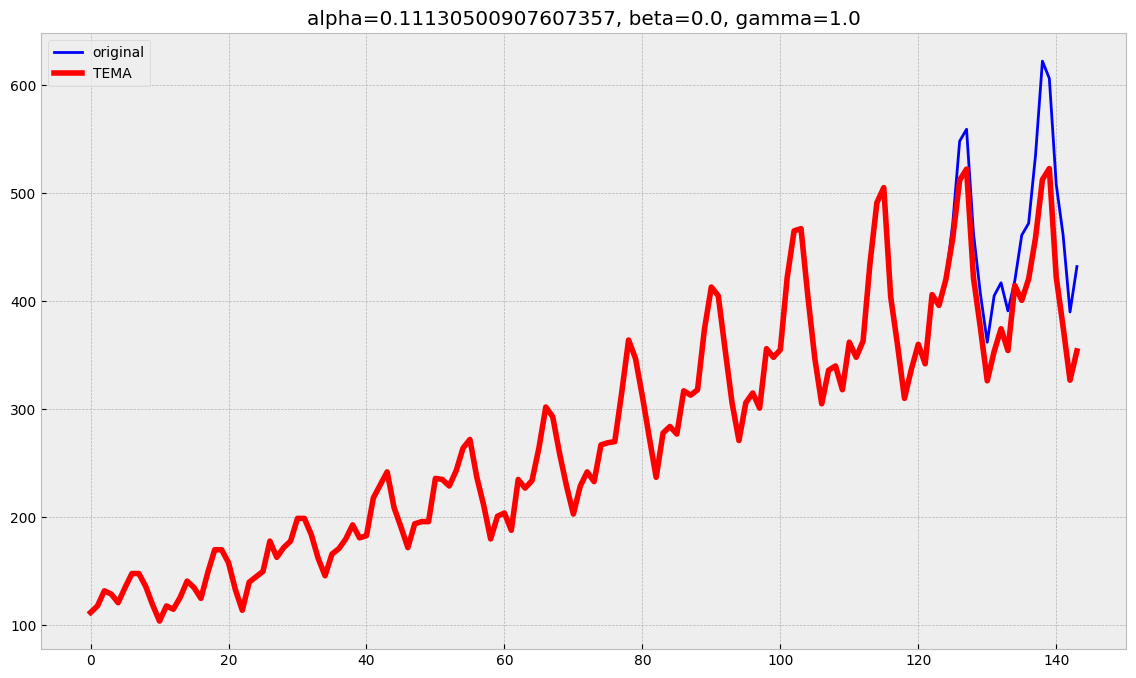

In [622]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Выводы:
1. В работе были построены различные скользящие средние от простой на стационаром ряду до тройного экспоненциального сглаживания с подбром параметров и применением кросс-валидации на трех различных нестационарных рядах;
2. По каждому методу была проведена оценка качества;
3. На стационарном ряде простая скользящая средняя с лагом 44 показала наиболее лучший результат и наименьшую ошибку;
4. На нестационаром ряде наиболее лучший результат был получен при использовании тройного экспоненциального сглаживания с подбором параметров, а так же при применении кросс-валидации;
5. В целом каждый из рассмотренных методов можно применять на различных рядах и в различных задачах
